In [1]:
#imports
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
NUM_ROUNDS = 5

plt.rcParams["figure.figsize"] = (12, 25) #(12,50)

#load in the image, collapse it from a 3d array to a 1d array of 3d points, finally convert the data to 32-bit integers
img = cv.imread('images/road_downscaled_smollestest.jpg')
Z = img.reshape((-1, 3))
Z = np.float32(Z)
# Z = np.int32(Z)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

90
62


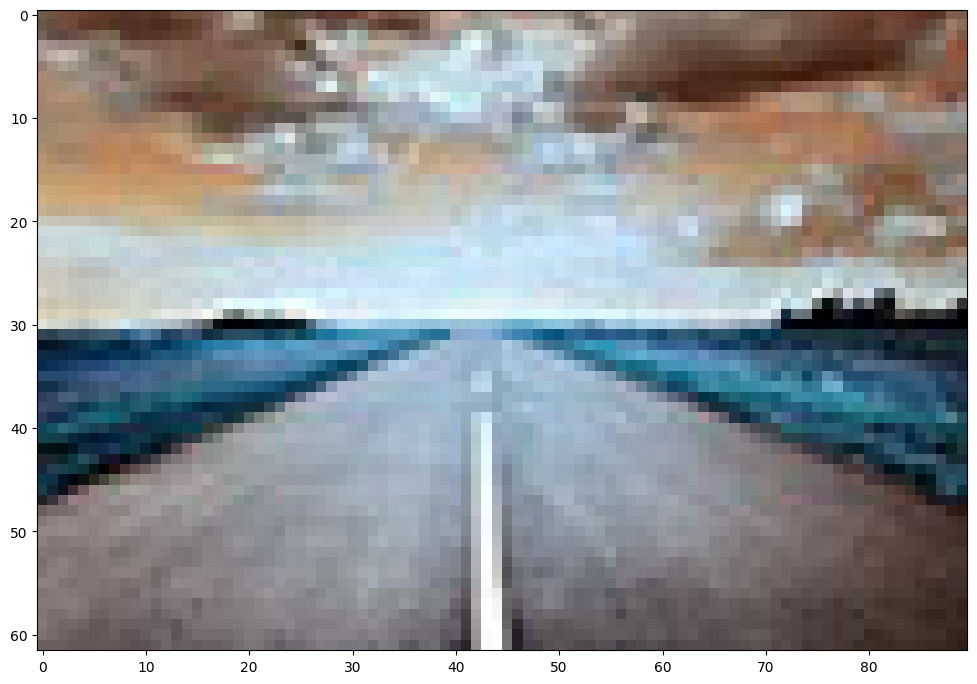

In [3]:
print(len(img[0])) #width
print(len(img)) #height

plt.imshow(img)

[[185.36172  201.29332  209.44057 ]
 [142.90224  137.67174  134.9408  ]
 [ 69.59938   72.038765  76.05723 ]]


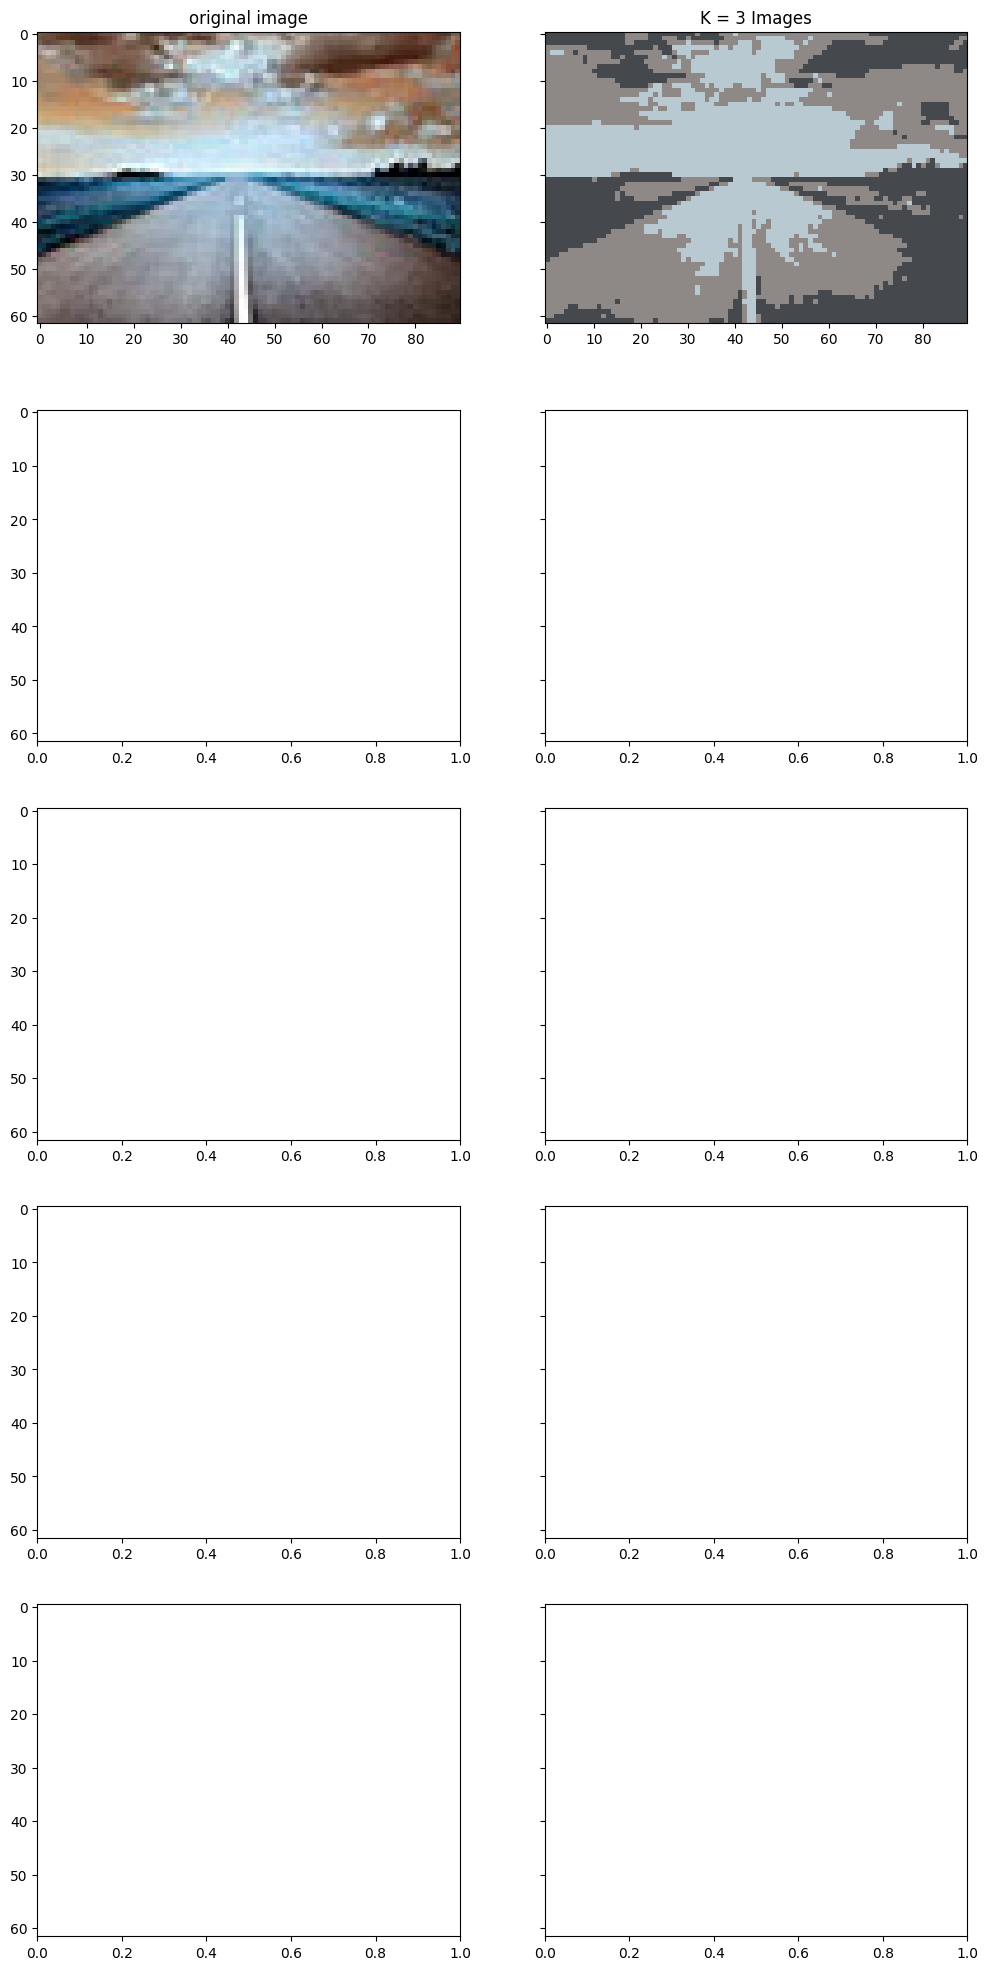

In [42]:
fig, ax = plt.subplots(NUM_ROUNDS, 2, sharey=True)
# print(Z)
for i in range(1):
    K = i+3

    ret, label, center = cv.kmeans(Z, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)

    print(center)
    # print(center[label.flatten()].reshape((img.shape)))
    
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    ax[i, 1].imshow(res2)
    ax[i, 1].set_title('K = %s Images' %K)
    ax[i, 0].imshow(img)
    ax[i, 0].set_title('original image')

In [5]:
#pyspark import huppeldepup
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets as D
from scipy.spatial import distance_matrix

from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [6]:
class UndirectedWeightedGraph:
    def __init__(self, edge_weights, vertices):
        self.__edge_weights = edge_weights
        self.__vertices = vertices
        
    def vertices(self):
        # copy?
        return self.__vertices
        
    def weight(self, v1, v2):
        if v1 < v2 and v1 in self.__edge_weights and v2 in self.__edge_weights[v1]:
            return self.__edge_weights[v1][v2]
        elif v2 < v1 and v2 in self.__edge_weights and v1 in self.__edge_weights[v2]:
            return self.__edge_weights[v2][v1]
        else:
            return math.inf
        
    def neighbourhood(self, vertex):
        print("HOWDY")
        n = []
        
        if vertex in self.__edge_weights.keys():
            for v in self.__edge_weights[vertex].keys():
                n.append((v, self.__edge_weights[vertex][v]))

        for v in range(vertex):
            if v in self.__edge_weights.keys() and vertex in self.__edge_weights[v].keys():
                n.append((v, self.__edge_weights[v][vertex]))
                
        return n

In [7]:
# create an edge dictionary
edges = {}
for i in range(len(Z)):
    edges_vertex = {}
    for j in range(i+1, len(Z)):
        edges_vertex[j] = (Z[i][0] - Z[j][0])**2 + (Z[i][1] - Z[j][1])**2 + (Z[i][2] - Z[j][2])**2
    edges[i] = edges_vertex

In [8]:
graph = UndirectedWeightedGraph(edges, [i for i in range(len(Z))])

In [9]:
graph.weight(2, 5) #this function is super slow when using the distance_matrix instead of the edge_dictionary, no idea why

np.float32(738.0)

In [10]:
spark = (SparkSession
    .builder
    .appName("Affinity Clustering")
    .getOrCreate())

In [11]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Affinity Clustering>

In [12]:
# def find_best_neighbor_map(x):
#     vertex, neighbourhood = x
#     return (vertex, min(neighbourhood, key=lambda n:n[1])[0])
def find_best_neighbor_map(vertex):
    return (vertex, min(graph.vertices(), key=lambda v: graph.weight(vertex, v)))

def find_best_neighbor_mpc(graph):
    # findbestneighbors_input = [(v, graph.neighbourhood(v)) for v in graph.vertices()]
    findbestneighbors_input = graph.vertices()

    best_neighbors = (sc.parallelize(findbestneighbors_input)
        .map(lambda x: find_best_neighbor_map(x))
        .collect())
    
    best_neighbor_m = {}
    for vertex, neighbor in best_neighbors:
        best_neighbor_m[vertex] = neighbor
        
    return best_neighbor_m

In [13]:
# not efficient, can be combined with contraction_mpc_map
# still doing it like this for clarity
# def find_leader_map(x, best_neighbor_m):
#     vertex, neighbourhood = x
#     c = vertex
#     v = vertex
#     S = []
    
#     while v not in S:
#         S.append(v)
#         c = min(c, v)
#         v = best_neighbor_m[v]
        
#     return (vertex, c)

def find_leader_map(vertex, best_neighbor):
    c = vertex
    v = vertex
    S = []

    while v not in S:
        S.append(v)
        c = min(c, v)
        v = best_neighbor[v]

    return (vertex, c)

def find_leader_mpc(graph, best_neighbor):
    # find_leader_input = [(v, [n[0] for n in graph.neighbourhood(v)]) for v in graph.vertices()]
    find_leader_input = graph.vertices()
    
    leaders = (sc.parallelize(find_leader_input)
        .map(lambda x: find_leader_map(x, best_neighbor))
        .collect())
    
    leader_m = {}
    for vertex, leader in leaders:
        leader_m[vertex] = leader
    
    return leader_m

In [14]:
# can be simplified, combine this with find leader
def contraction_mpc_map(x, best_neighbor_m):
    vertex, neighbourhood = x
    c = vertex
    v = vertex
    S = []
    
    while v not in S:
        S.append(v)
        c = min(c, v)
        v = best_neighbor_m[v]
    
    return (c, neighbourhood)

def contraction_mpc_reduce(x, best_neighbor_m, leader_m):
    c, neighborhoods = x
    
    neighborhood = [ v for n in neighborhoods for v in n ]
    
    # reroute edges to leaders
    neighborhood = [ (leader_m[v], w) for v, w in neighborhood ]
    # remove edges pointing to c
    neighborhood = [ (v, w) for v, w in neighborhood if v != c ]
    # choose edges with smallest weight
    neighbor_weights = {}
    for v, w in neighborhood:
        if not v in neighbor_weights:
            neighbor_weights[v] = [w]
        else:
            neighbor_weights[v].append(w)
    neighborhood = []
    for n in neighbor_weights:
        neighborhood.append((n, min(neighbor_weights[n])))
    
    return (c, neighborhood)

def contraction_mpc(graph, best_neighbor_m, leader_m):
    def to_list(a):
        return [a]

    def append(a, b):
        a.append(b)
        return a

    def extend(a, b):
        a.extend(b)
        return a
    
    contraction_input = [(v, [n for n in graph.neighbourhood(v)]) for v in graph.vertices()]
    
    return (sc.parallelize(contraction_input)
        .map(lambda x: contraction_mpc_map(x, best_neighbor_m))
        .combineByKey(to_list, append, extend)
        .map(lambda x: contraction_mpc_reduce(x, best_neighbor_m, leader_m))
        .collect())

In [17]:
#TODO: update code so current graph is modified, rather than copied

def create_graph(contraction_mpc_result):
    vertices = []
    edges = {}
    
    # TODO: don't add empty dicts
    for vertex, neighbors in contraction_mpc_result:
        vertices.append(vertex)
        edges[vertex] = {}
        for neighbor, weight in neighbors:
            if neighbor > vertex:
                edges[vertex][neighbor] = weight
                
    return UndirectedWeightedGraph(edges, vertices)
        
# def affinity_clustering(graph, steps=1):
#     result = []
    
#     mapping = {}
#     for v in graph.vertices():
#         mapping[v] = v
    
#     # is a deepcopy needed?
#     graph_prime = copy.deepcopy(graph)
    
#     for step in range(steps):
#         best_neighbor_m = find_best_neighbor_mpc(graph_prime)
#         leader_m = find_leader_mpc(graph_prime, best_neighbor_m)
        
#         for v in graph.vertices():
#             mapping[v] = leader_m[mapping[v]]
#         result.append(copy.deepcopy(mapping))
        
#         contraction_mpc_result = contraction_mpc(graph_prime, best_neighbor_m, leader_m)
#         graph_prime = create_graph(contraction_mpc_result)
        
#     return result

def affinity_clustering(graph, steps=1):
    result = []
    mapping = {}
    for v in graph.vertices():
        mapping[v] = v

    print("bing")
    best_neighbor = find_best_neighbor_mpc(graph)
    print("bong")
    leader = find_leader_mpc(graph, best_neighbor)
    print("boong")

    for v in graph.vertices():
        mapping[v] = leader[mapping[v]]

    result.append(mapping)

    #todo contract graph

    return result

In [18]:
result = affinity_clustering(graph) #this is running into heap issues

bing
bong
boong


In [38]:
Z

array([[113.,  92.,  70.],
       [112.,  85.,  64.],
       [113.,  78.,  58.],
       ...,
       [ 58.,  42.,  36.],
       [ 53.,  37.,  31.],
       [ 46.,  30.,  24.]], dtype=float32)

Text(0.5, 1.0, 'original image')

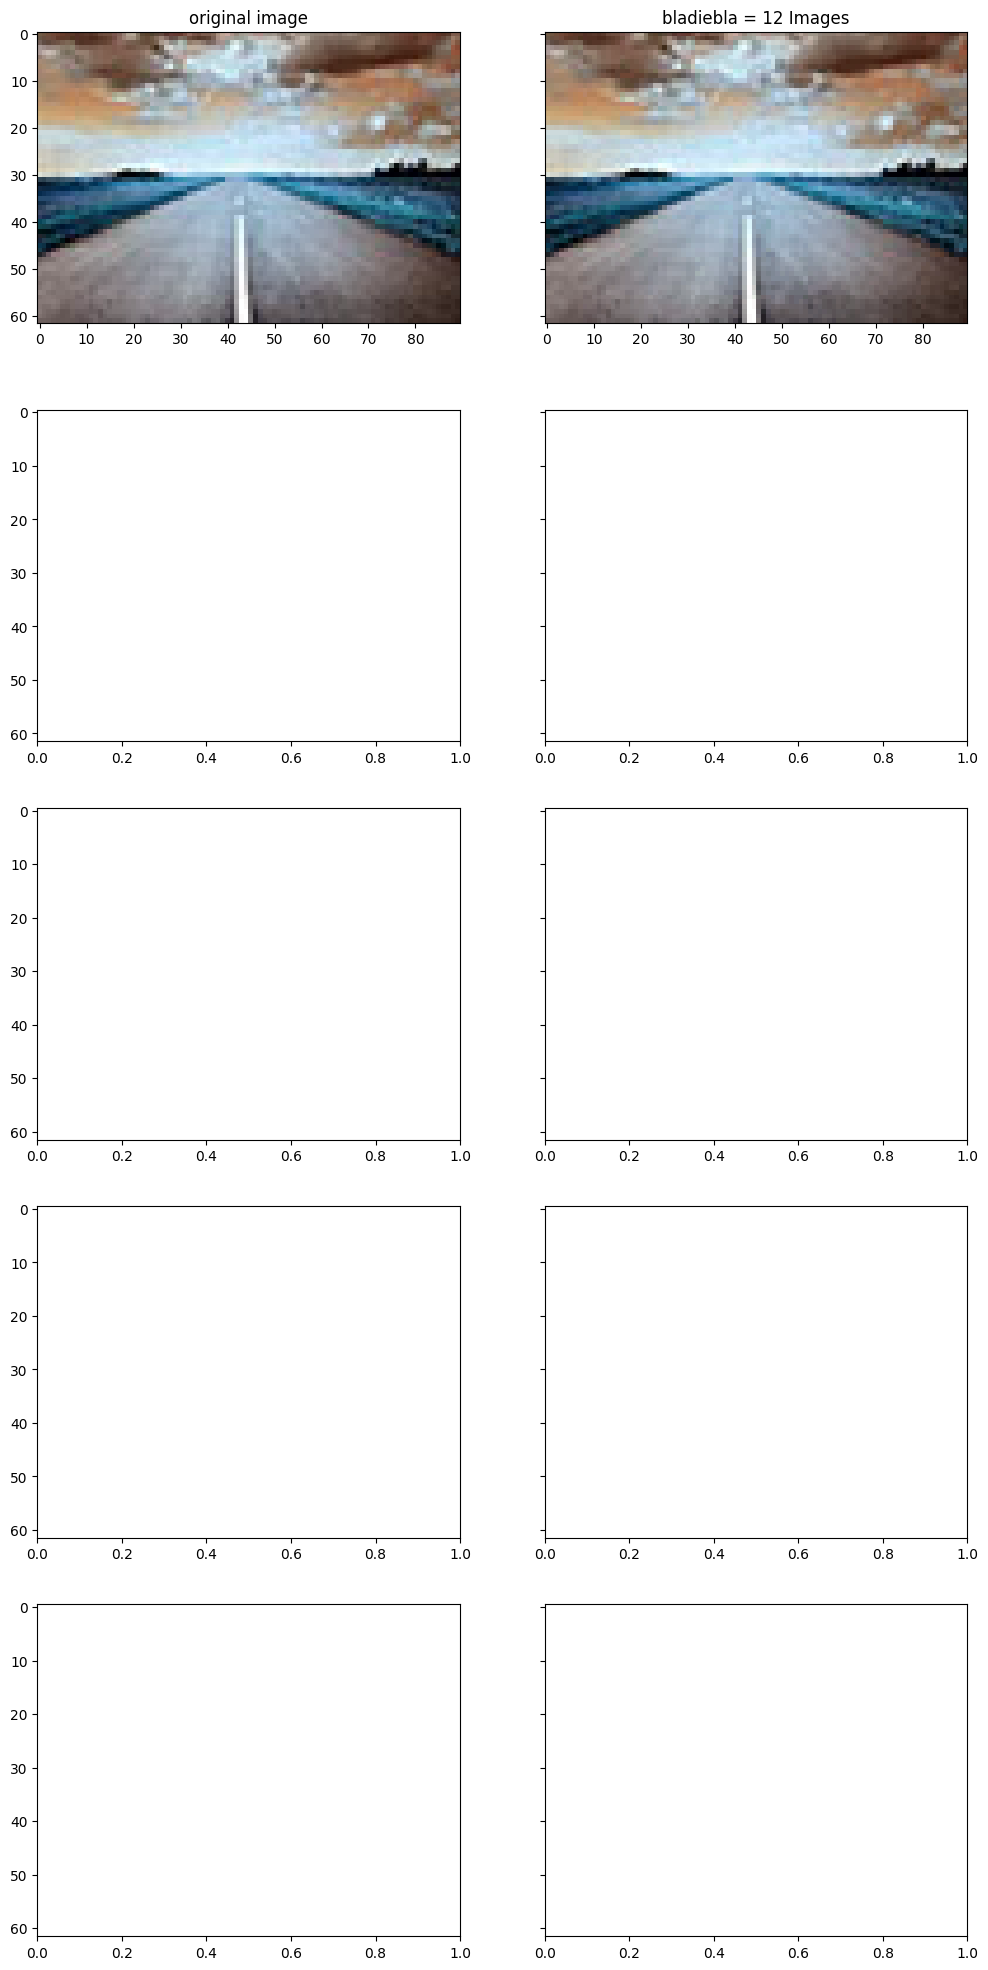

In [50]:
fig, ax = plt.subplots(NUM_ROUNDS, 2, sharey=True)
# result contains a mapping from a vertex to the leader it belongs to
# result
# result[0]

res = np.uint8([Z[result[0][l]] for l in result[0]])
res2 = res.reshape((img.shape))

res2
ax[i, 1].imshow(res2)
ax[i, 1].set_title('bladiebla = %s Images' %12)
ax[i, 0].imshow(img)
ax[i, 0].set_title('original image')
#TODO: visualize